### Data preparation and plotting for Figure 9, 10, and 11 in Stan and Mantripragada (2023)

Reconstruction of MJO anomalies based on Kikuchi et al 2012 \
Three different ways the MJO anomalies are reconstructed: \
Reconstructing MJO anomalies by projecting PCs onto the Lanczos filtered 25-90-day anomalies \
Reconstructing MJO anomalies by projecting PCs onto the daily OLR anomalies (based on Kikuchi et al 2012) \
Reconstructing MJO anomalies by projecting PCs onto the CNN filtered 25-90-day anomalies 

In [1]:
import numpy as np
import xarray as xr
import proplot as pplt
import copy
from scipy import signal
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

In [2]:
def smooth_clim(data):   
    
    """    
    Smooths the input climate data by calculating daily climatology and applying a low-pass
    Fourier filter to retain only the first few harmonic components of the annual cycle.
    Args:
    data (xarray.DataArray or xarray.Dataset): Input climate data with a "time" dimension.
    Returns:
        smclim (xarray.DataArray or xarray.Dataset): Smoothed climatology data with the same 
            dimensions and coordinates as the input data.
    Notes:
        - This function assumes that the input data is daily data and is evenly spaced in time.
        - The number of harmonics to retain is determined by the variable `nharm`. In this
          implementation, `nharm` is set to 3.
    """
    
    # Calculate daily climatology
    clim = data.groupby("time.dayofyear").mean("time")
    # smoothed annual cycle
    nharm = 3
    fft = np.fft.rfft(clim, axis=0)
    fft[nharm] = 0.5*fft[nharm]
    fft[nharm+1:] = 0
    dataout = np.fft.irfft(fft, axis=0)
    smclim = copy.deepcopy(clim)
    smclim[:] = dataout 

    return smclim

def filtwghts_lanczos(nwt, filt_type, fca, fcb):
	
    """
    Calculates the Lanczos filter weights.
    
    Parameters
    ----------
    nwt : int
        The number of weights.
    filt_type : str
        The type of filter. Must be one of 'low', 'high', or 'band'.
    fca : float
        The cutoff frequency for the low or band filter.
    fcb : float
        The cutoff frequency for the high or band filter.
    
    Returns
    -------
    w : ndarray
        The Lanczos filter weights.
    
    Notes
    -----
    The Lanczos filter is a type of sinc filter that is truncated at a specified frequency.
    This function implements a Lanczos filter in the time domain.
    """	
	
    pi = np.pi
    k = np.arange(-nwt, nwt+1)

    if filt_type == 'low':
        w = np.zeros(nwt*2+1)
        w[:nwt] = ((np.sin(2 * pi * fca * k[:nwt]) / (pi * k[:nwt])) * np.sin(pi * k[:nwt] / nwt) / (pi * k[:nwt] / nwt))
        w[nwt+1:] = ((np.sin(2 * pi * fca * k[nwt+1:]) / (pi * k[nwt+1:])) * np.sin(pi * k[nwt+1:] / nwt) / (pi * k[nwt+1:] / nwt))
        w[nwt] = 2 * fca
    elif filt_type == 'high':
        w = np.zeros(nwt*2+1)
        w[:nwt] = -1 * (np.sin(2 * pi * fcb * k[:nwt]) / (pi * k[:nwt])) * np.sin(pi * k[:nwt] / nwt) / (pi * k[:nwt] / nwt)
        w[nwt+1:] = -1 * (np.sin(2 * pi * fcb * k[nwt+1:]) / (pi * k[nwt+1:])) * np.sin(pi * k[nwt+1:] / nwt) / (pi * k[nwt+1:] / nwt)
        w[nwt] = 1 - 2 * fcb
    else:
        w1 = np.zeros(nwt*2+1)
        w1[:nwt] = (np.sin(2 * pi * fca * k[:nwt]) / (pi * k[:nwt])) * np.sin(pi * k[:nwt] / nwt) / (pi * k[:nwt] / nwt)
        w1[nwt+1:] = (np.sin(2 * pi * fca * k[nwt+1:]) / (pi * k[nwt+1:])) * np.sin(pi * k[nwt+1:] / nwt) / (pi * k[nwt+1:] / nwt)
        w1[nwt] = 2 * fca
        w2 = np.zeros(nwt*2+1)
        w2[:nwt] = (np.sin(2 * pi * fcb * k[:nwt]) / (pi * k[:nwt])) * np.sin(pi * k[:nwt] / nwt) / (pi * k[:nwt] / nwt)
        w2[nwt+1:] = (np.sin(2 * pi * fcb * k[nwt+1:]) / (pi * k[nwt+1:])) * np.sin(pi * k[nwt+1:] / nwt) / (pi * k[nwt+1:] / nwt)
        w2[nwt] = 2 * fcb
        w = w2 - w1
		
    return w

### The below function is from METcalcpy

def phase_diagram(indexname,PC1,PC2,dates,months,days,plotname='./MJO_phase_diagram',plottype='png'):
    """
    Plot phase diagram for OMI or RMM. Do not flip the sign and PCs for OMI before
    passing to the routine.
    :param indexname: name of index, should be either OMI or RMM
    :type indexname: string
    :param PC1: first principal component, either from observations or computed
    :param PC2: second principal component, either from observations or computed
    :param dates: numpy array of dates
    :param months: numpy array of month integers for each time in PC1 and PC2
    :param days: numpy array of day of month intergers for each time in PC1 and PC2
    :param plotname: name of figure file
    :param plottype: type of figure file to save
    :return: none
    """

    #####################################################
    # set parameters and settings for plot
    monthnames = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    colors = ['black','gold','tab:purple','tab:red','darkgreen','tab:orange',
    'tab:blue','tab:grey','tab:green','tab:pink','tab:olive','tab:cyan']

    nMon            = 0
    monName         = [monthnames[months[0]-1]]
    monCol          = [colors[months[0]-1]]

    # plot phase diagram
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # lines to separate the phases  
    plt.plot([-4,4],[-4,4],linewidth=0.2,linestyle='--',color='k')
    plt.plot([-4,4],[4,-4],linewidth=0.2,linestyle='--',color='k')
    plt.plot([-4,4],[0,0],linewidth=0.2,linestyle='--',color='k')
    plt.plot([0,0],[-4,4],linewidth=0.2,linestyle='--',color='k')
    plt.xlim([-4.0,4.0])
    plt.ylim([-4.0,4.0])

    # circle in the center of the plot to denote weak index  
    circle = plt.Circle((0, 0), radius=1.0, fc='k', ec='k', alpha=0.2)
    plt.gca().add_patch(circle)

    # cycle over dates and plot the two princial components against each other  
    alph=1.0
    time = dates
    labelday = 5  # label every fifth day

    # start marker
    plt.plot(PC1[0],PC2[0],color='k',marker='o',markersize=5)
    # loop through dates and plot line from current to next time 
    for im in np.arange(0,len(months)-1):
        lcolor = colors[months[im]-1]
        plt.plot(PC1[im:im+2],PC2[im:im+2],'-',color=lcolor,alpha=alph)
        plt.plot(PC1[im],PC2[im],color='k',alpha=alph,marker='o',markersize=2)
        # text labels for the days
        if days[im]%labelday==0:
            plt.text(PC1[im],PC2[im],str(days[im]),color='k')
        # get current month color for month labels
        if im>0 and days[im]==1:
            nMon = nMon+1
            monName.append(monthnames[months[im]-1])
            monCol.append(colors[months[im]-1])   
    # last date marker        
    plt.plot(PC1[len(months)-1],PC2[len(months)-1],color='k',alpha=alph,marker='o',markersize=2)    

    # axis labels and title 
    #plt.xlabel(indexname+'1')
    #plt.ylabel(indexname+'2')
    plt.title(indexname+' '+str(dates.min())+' to '+str(dates.max()))

    # axes
    ax.set_aspect('equal')
    ax.tick_params(bottom=True, top=True, left=True, right=True,which='both')
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    # text for phases
    plt.text(0.5, 0.99, "Phase 7 (Western Pacific) Phase 6", horizontalalignment='center', verticalalignment='top',
    transform=ax.transAxes)
    plt.text(0.55, 0.01, "Phase 2 (Indian) Phase 3", horizontalalignment='center', verticalalignment='bottom',
    transform=ax.transAxes)
    plt.text(0.99, 0.5, "Phase 5 (Maritime) Phase 4", horizontalalignment='right', verticalalignment='center',
    transform=ax.transAxes,rotation=-90)
    plt.text(0.01, 0.5, "Phase 1 (Western Hem, Africa) Phase 8", horizontalalignment='left', verticalalignment='center',
    transform=ax.transAxes,rotation=90)

    # text for month names
    xstrt=0.01
    for im in np.arange(0,nMon+1,1):
        plt.text(xstrt, 0.01, monName[im], color=monCol[im], horizontalalignment='left', verticalalignment='bottom',
        transform=ax.transAxes)
        xstrt=xstrt+0.08

    # save figure to file
    plt.savefig(plotname+'.'+plottype,format=plottype)

In [3]:
# The uninterpolated OLR data is downloaded form:
# https://downloads.psl.noaa.gov/Datasets/uninterp_OLR/olr.day.mean.nc
# Kikuchi used non-interpolated OLR for real time monitoring and used interpolated daily OLR to extract MJO mode

# non-interpolated daily mean data
olrni = xr.open_dataset('olr.day.uninterpolated.mean.nc').olr
# Reverse the latitude (from 90,-90 to -90,90) and then extract the data between -30 to 30 
# and finally interpolate spatially and temporally for missing data.
olrni = olrni.reindex(lat=olrni.lat[::-1]).sel(lat=slice(-30,30)).interpolate_na(dim='lon').interpolate_na(dim='time').sel(time=slice(None,'2019-03-31'))

# interpolated daily mean data
olri = xr.open_dataset('olr.day.interpolated.mean.nc').olr 
olri = olri.reindex(lat=olri.lat[::-1]).sel(lat=slice(-30,30)).sel(time=slice('1979-01-01','2019-06-09'))

### Calculate OLR anomalies (interpolated and uninterpolated) based on smoothed annual cycle (1979-2009) of interpolated data

In [4]:
olri_clim = smooth_clim(olri.sel(time=slice('1979','2009')))

olrni_anom = olrni.groupby("time.dayofyear") - olri_clim  # uninterpolated
olri_anom = olri.groupby("time.dayofyear") - olri_clim  # interpolated

del olri_anom['dayofyear']
del olrni_anom['dayofyear']

olri_anom = olri_anom.sel(time=slice('2001-10-23',None))

### Calculate 25-90-day band pass filtered anomalies
nweights = 70*2 + 1 = 141

In [5]:
# Computing the 25-90-day filtered anomalies of non-interpolated OLR daily anomalies
## Get the Lanczos filter weights for 25-90-day 
wgths = filtwghts_lanczos(70,'band',1/90,1/25)
wgths = xr.DataArray(wgths, dims=['window'])
# Calculating 25-90-day filtered anomalies
olri_lcz = olri_anom.rolling(time=len(wgths), center=True).construct('window').dot(wgths)


### Reshape the data

In [6]:
olri_lcz_rg = olri_lcz.stack(grid=("lat","lon")).transpose("time","grid")

olri_lcz = olri_lcz.dropna(dim='time')
olri_lcz_rg = olri_lcz_rg.dropna(dim='time')

olri_anom = olri_anom.sel(time=slice('2002','2019-03-31'))
olrni_anom_rg = olrni_anom.stack(grid=("lat","lon")).transpose("time","grid")

### Load Exteneded EOFs

The spatial-temporal patterns of the MJO is identified with the extended empirical orthogonal function (EEOF) analysis \
of 31 years (1979-2009) OLR data for the December-January-February-March-April. \
To extract intraseasonal variability, Lanczos band-pass filter (Duchon 1979) with cut-off periods 25 and 90 days and 141 weights \
was applied to the daily OLR data before performing the EEOF analysis.

The EEOFs and PCs (based on Kikuchi 2020) is downloaded from:\
http://iprc.soest.hawaii.edu/users/kazuyosh/ISO_index/data/olr.7917_01.25-90bpfil.DJFMA.eeof_evec.nc

In [7]:
ds = xr.open_dataset('olr.7917_01.25-90bpfil.DJFMA.eeof_evec.nc');

evec0 = ds.evec0.sel(lat=slice(-30,30))
evec0[0,:,:] = -evec0[0,:,:]
evec0_rg = evec0.stack(grid=("lat","lon")).transpose("time","grid")

evec1 = ds.evec1.sel(lat=slice(-30,30))
evec1[0,:,:] = -evec1[0,:,:]
evec1_rg = evec1.stack(grid=("lat","lon")).transpose("time","grid")

evec2 = ds.evec2.sel(lat=slice(-30,30))
evec2[0,:,:] = -evec2[0,:,:]
evec2_rg = evec2.stack(grid=("lat","lon")).transpose("time","grid")

/homes/rmantrip/.conda/envs/plotting/lib/python3.8/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/homes/rmantrip/.conda/envs/plotting/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/homes/rmantrip/.conda/envs/plotting/lib/python3.8/site-packages/xarray/core/indexing.py:423: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime

#### Reconstructing MJO anomalies by projecting PCs onto the Lanczos filtered 25-90-day anomalies

In [8]:
## Shift the data by 10,5,0 days

exa1 = olri_lcz_rg.shift(time=10)
exa2 = olri_lcz_rg.shift(time=5)
exa3 = olri_lcz_rg.shift(time=0)

# Lanczos

pcsa1 = exa1.data@evec0_rg.T.data
pcsa2 = exa2.data@evec1_rg.T.data
pcsa3 = exa3.data@evec2_rg.T.data

pcsa1 = pcsa1[10:,:]
pcsa2 = pcsa2[10:,:]
pcsa3 = pcsa3[10:,:]

pca1 = xr.DataArray(pcsa1, dims=['time','pc'])
pca1['time'] = olri_lcz_rg.time[10:]

pca2 = xr.DataArray(pcsa2, dims=['time','pc'])
pca2['time'] = olri_lcz_rg.time[10:]

pca3 = xr.DataArray(pcsa3, dims=['time','pc'])
pca3['time'] = olri_lcz_rg.time[10:]

pca = pca1 + pca2 + pca3

pca_std = np.expand_dims(np.nanstd(pca,axis=0),axis=0)

pca = pca/pca_std

# ###################################################################################################

dat = copy.deepcopy(olri_lcz_rg[10:,:])

tt1 = np.expand_dims(evec0_rg.T[:,0],axis=1)@np.expand_dims(pca1.T[0,:],axis=0) + np.expand_dims(evec0_rg.T[:,1],axis=1)@np.expand_dims(pca1.T[1,:],axis=0)
tt2 = np.expand_dims(evec1_rg.T[:,0],axis=1)@np.expand_dims(pca2.T[0,:],axis=0) + np.expand_dims(evec1_rg.T[:,1],axis=1)@np.expand_dims(pca2.T[1,:],axis=0)
tt3 = np.expand_dims(evec2_rg.T[:,0],axis=1)@np.expand_dims(pca3.T[0,:],axis=0) + np.expand_dims(evec2_rg.T[:,1],axis=1)@np.expand_dims(pca3.T[1,:],axis=0)

tt = tt1+tt2+tt3

datT = dat.T
datT[:] = np.nan
datT[:] = tt
olrlcz_mjo = datT.unstack()

#### Reconstructing MJO anomalies by projecting PCs onto the daily OLR anomalies (based on Kikuchi et al 2012)

In [9]:
# Prepring the OLR anomalies based on Kikuchi
## Subtracting the mean of last 40 days of olr anomalies (based on smoothed climatology)
exa = copy.deepcopy(olrni_anom[40:,:,:])
exa[:] = np.nan

for i in range(exa.shape[0]):
    exa[i,:,:] = olrni_anom[40+i,:,:] - olrni_anom[i:40+i,:,:].mean('time')
      
## 5-day tapered running mean  
exb = exa.rolling(time=5,center=True).mean()
exb[0,:,:] = exa[0,:,:]
exb[-1,:,:] = exa[-1,:,:]

exb[1,:,:] = exa[0:3,:,:].mean('time')
exb[-2,:,:] = exa[-3:,:,:].mean('time')

# Reshape the data
exb_rg = exb.stack(grid=("lat","lon")).transpose("time","grid")

exb1 = exb_rg.shift(time=10)
exb2 = exb_rg.shift(time=5)
exb3 = exb_rg.shift(time=0)

pcsb1 = exb1.data@evec0_rg.T.data#@ex1.T.data
pcsb2 = exb2.data@evec1_rg.T.data#@ex2.T.data
pcsb3 = exb3.data@evec2_rg.T.data#@ex3.T.data

pcsb1 = pcsb1[10:,:]
pcsb2 = pcsb2[10:,:]
pcsb3 = pcsb3[10:,:]

pcb1 = xr.DataArray(pcsb1, dims=['time','pc'])
pcb1['time'] = exb.time[10:]

pcb2 = xr.DataArray(pcsb2, dims=['time','pc'])
pcb2['time'] = exb.time[10:]

pcb3 = xr.DataArray(pcsb3, dims=['time','pc'])
pcb3['time'] = exb.time[10:]

pcb = pcb1 + pcb2 + pcb3

pcb_std = np.expand_dims(np.nanstd(pcb,axis=0),axis=0)

pcb = pcb/pcb_std


dat = copy.deepcopy(exb_rg[10:,:])

tt1 = np.expand_dims(evec0_rg.T[:,0],axis=1)@np.expand_dims(pcb1.T[0,:],axis=0) + np.expand_dims(evec0_rg.T[:,1],axis=1)@np.expand_dims(pcb1.T[1,:],axis=0)
tt2 = np.expand_dims(evec1_rg.T[:,0],axis=1)@np.expand_dims(pcb2.T[0,:],axis=0) + np.expand_dims(evec1_rg.T[:,1],axis=1)@np.expand_dims(pcb2.T[1,:],axis=0)
tt3 = np.expand_dims(evec2_rg.T[:,0],axis=1)@np.expand_dims(pcb3.T[0,:],axis=0) + np.expand_dims(evec2_rg.T[:,1],axis=1)@np.expand_dims(pcb3.T[1,:],axis=0)
tt = tt1+tt2+tt3

datT = dat.T
datT.data = tt
olranom_mjo = datT.unstack()

pcb_comb = xr.concat([pca.sel(time=slice(None,'2018-12-31')),pcb.sel(time=slice('2019-01-01',None))],dim='time')

#### Reconstructing MJO anomalies by projecting PCs onto the CNN filtered 25-90-day anomalies

In [10]:
## Load weights of the CNN and extract 25-90 day Intraseasonal Variability
## The CNN model is trained for the full globe between -30 to 30. 
inPath = outPath = '/homes/rmantrip/testPyISV/cnnweights/olr/fulldomain/'

filt1 = np.loadtxt(inPath+'olr.filter1.txt', delimiter=',')
filt2 = np.loadtxt(inPath+'olr.filter2.txt', delimiter=',')

olrni_cnn_rg = copy.deepcopy(olrni_anom_rg)
olrni_cnn_rg[:] = np.nan

for i in range(filt1.shape[1]):
    LowPass = np.convolve(olrni_anom_rg[:,i],filt1[:,i],mode='same')
    HighPass = olrni_anom_rg[:,i] - LowPass
    olrni_cnn_rg[:,i] = np.convolve(HighPass,filt2[:,i],mode='same')
    
olrnicnn = olrni_cnn_rg.unstack()

exc1 = olrni_cnn_rg.shift(time=10)
exc2 = olrni_cnn_rg.shift(time=5)
exc3 = olrni_cnn_rg.shift(time=0)

pcsc1 = exc1.data@evec0_rg.T.data#@ex1.T.data
pcsc2 = exc2.data@evec1_rg.T.data#@ex2.T.data
pcsc3 = exc3.data@evec2_rg.T.data#@ex3.T.data

pcsc1 = pcsc1[10:,:]
pcsc2 = pcsc2[10:,:]
pcsc3 = pcsc3[10:,:]

pcc1 = xr.DataArray(pcsc1, dims=['time','pc'])
pcc1['time'] = olrni_cnn_rg.time[10:]

pcc2 = xr.DataArray(pcsc2, dims=['time','pc'])
pcc2['time'] = olrni_cnn_rg.time[10:]

pcc3 = xr.DataArray(pcsc3, dims=['time','pc'])
pcc3['time'] = olrni_cnn_rg.time[10:]


pcc = pcc1 + pcc2 + pcc3

pcc_std = np.expand_dims(np.nanstd(pcc,axis=0),axis=0)

pcc = pcc/pcc_std

dat = copy.deepcopy(olrni_cnn_rg[10:,:])

tt1 = np.expand_dims(evec0_rg.T[:,0],axis=1)@np.expand_dims(pcc1.T[0,:],axis=0) + np.expand_dims(evec0_rg.T[:,1],axis=1)@np.expand_dims(pcc1.T[1,:],axis=0)
tt2 = np.expand_dims(evec1_rg.T[:,0],axis=1)@np.expand_dims(pcc2.T[0,:],axis=0) + np.expand_dims(evec1_rg.T[:,1],axis=1)@np.expand_dims(pcc2.T[1,:],axis=0)
tt3 = np.expand_dims(evec2_rg.T[:,0],axis=1)@np.expand_dims(pcc3.T[0,:],axis=0) + np.expand_dims(evec2_rg.T[:,1],axis=1)@np.expand_dims(pcc3.T[1,:],axis=0)
tt = tt1+tt2+tt3

datT = dat.T
datT.data = tt
olrcnn_mjo = datT.unstack()

pcc_comb = xr.concat([pca.sel(time=slice(None,'2018-12-31')),pcc.sel(time=slice('2019-01-01',None))],dim='time')

In [11]:
## Combine the dataset 
## exb: anomalies according to Kikuchi
## olrni_lcz: 25-90-d based on Lanczos filter
## olrnicnn: 25-90-d filtered anomalies based on CNN filter
## olrcnnmjo: Reconstructed MJO based on olrnicnn

olr_comb = xr.concat([olri_lcz.sel(time=slice('2018-09-01','2018-12-31')),exb.sel(time=slice('2019-01-01','2019-03-31'))],dim='time')
olr_mjo_comb = xr.concat([olrlcz_mjo.sel(time=slice('2018-09-01','2018-12-31')),olranom_mjo.sel(time=slice('2019-01-01','2019-03-31'))],dim='time')

olrnicnn_comb = xr.concat([olri_lcz.sel(time=slice('2018-09-01','2018-12-31')),olrnicnn.sel(time=slice('2019-01-01','2019-03-31'))],dim='time')
olrcnnmjo_comb = xr.concat([olrlcz_mjo.sel(time=slice('2018-09-01','2018-12-31')),olrcnn_mjo.sel(time=slice('2019-01-01','2019-03-31'))],dim='time') 

olrni_cnnlat = olrnicnn_comb.sel(lat=slice(-7.5,7.5)).mean('lat')
olrcnnmjolat = olrcnnmjo_comb.sel(lat=slice(-7.5,7.5)).mean('lat')

### Figure 9

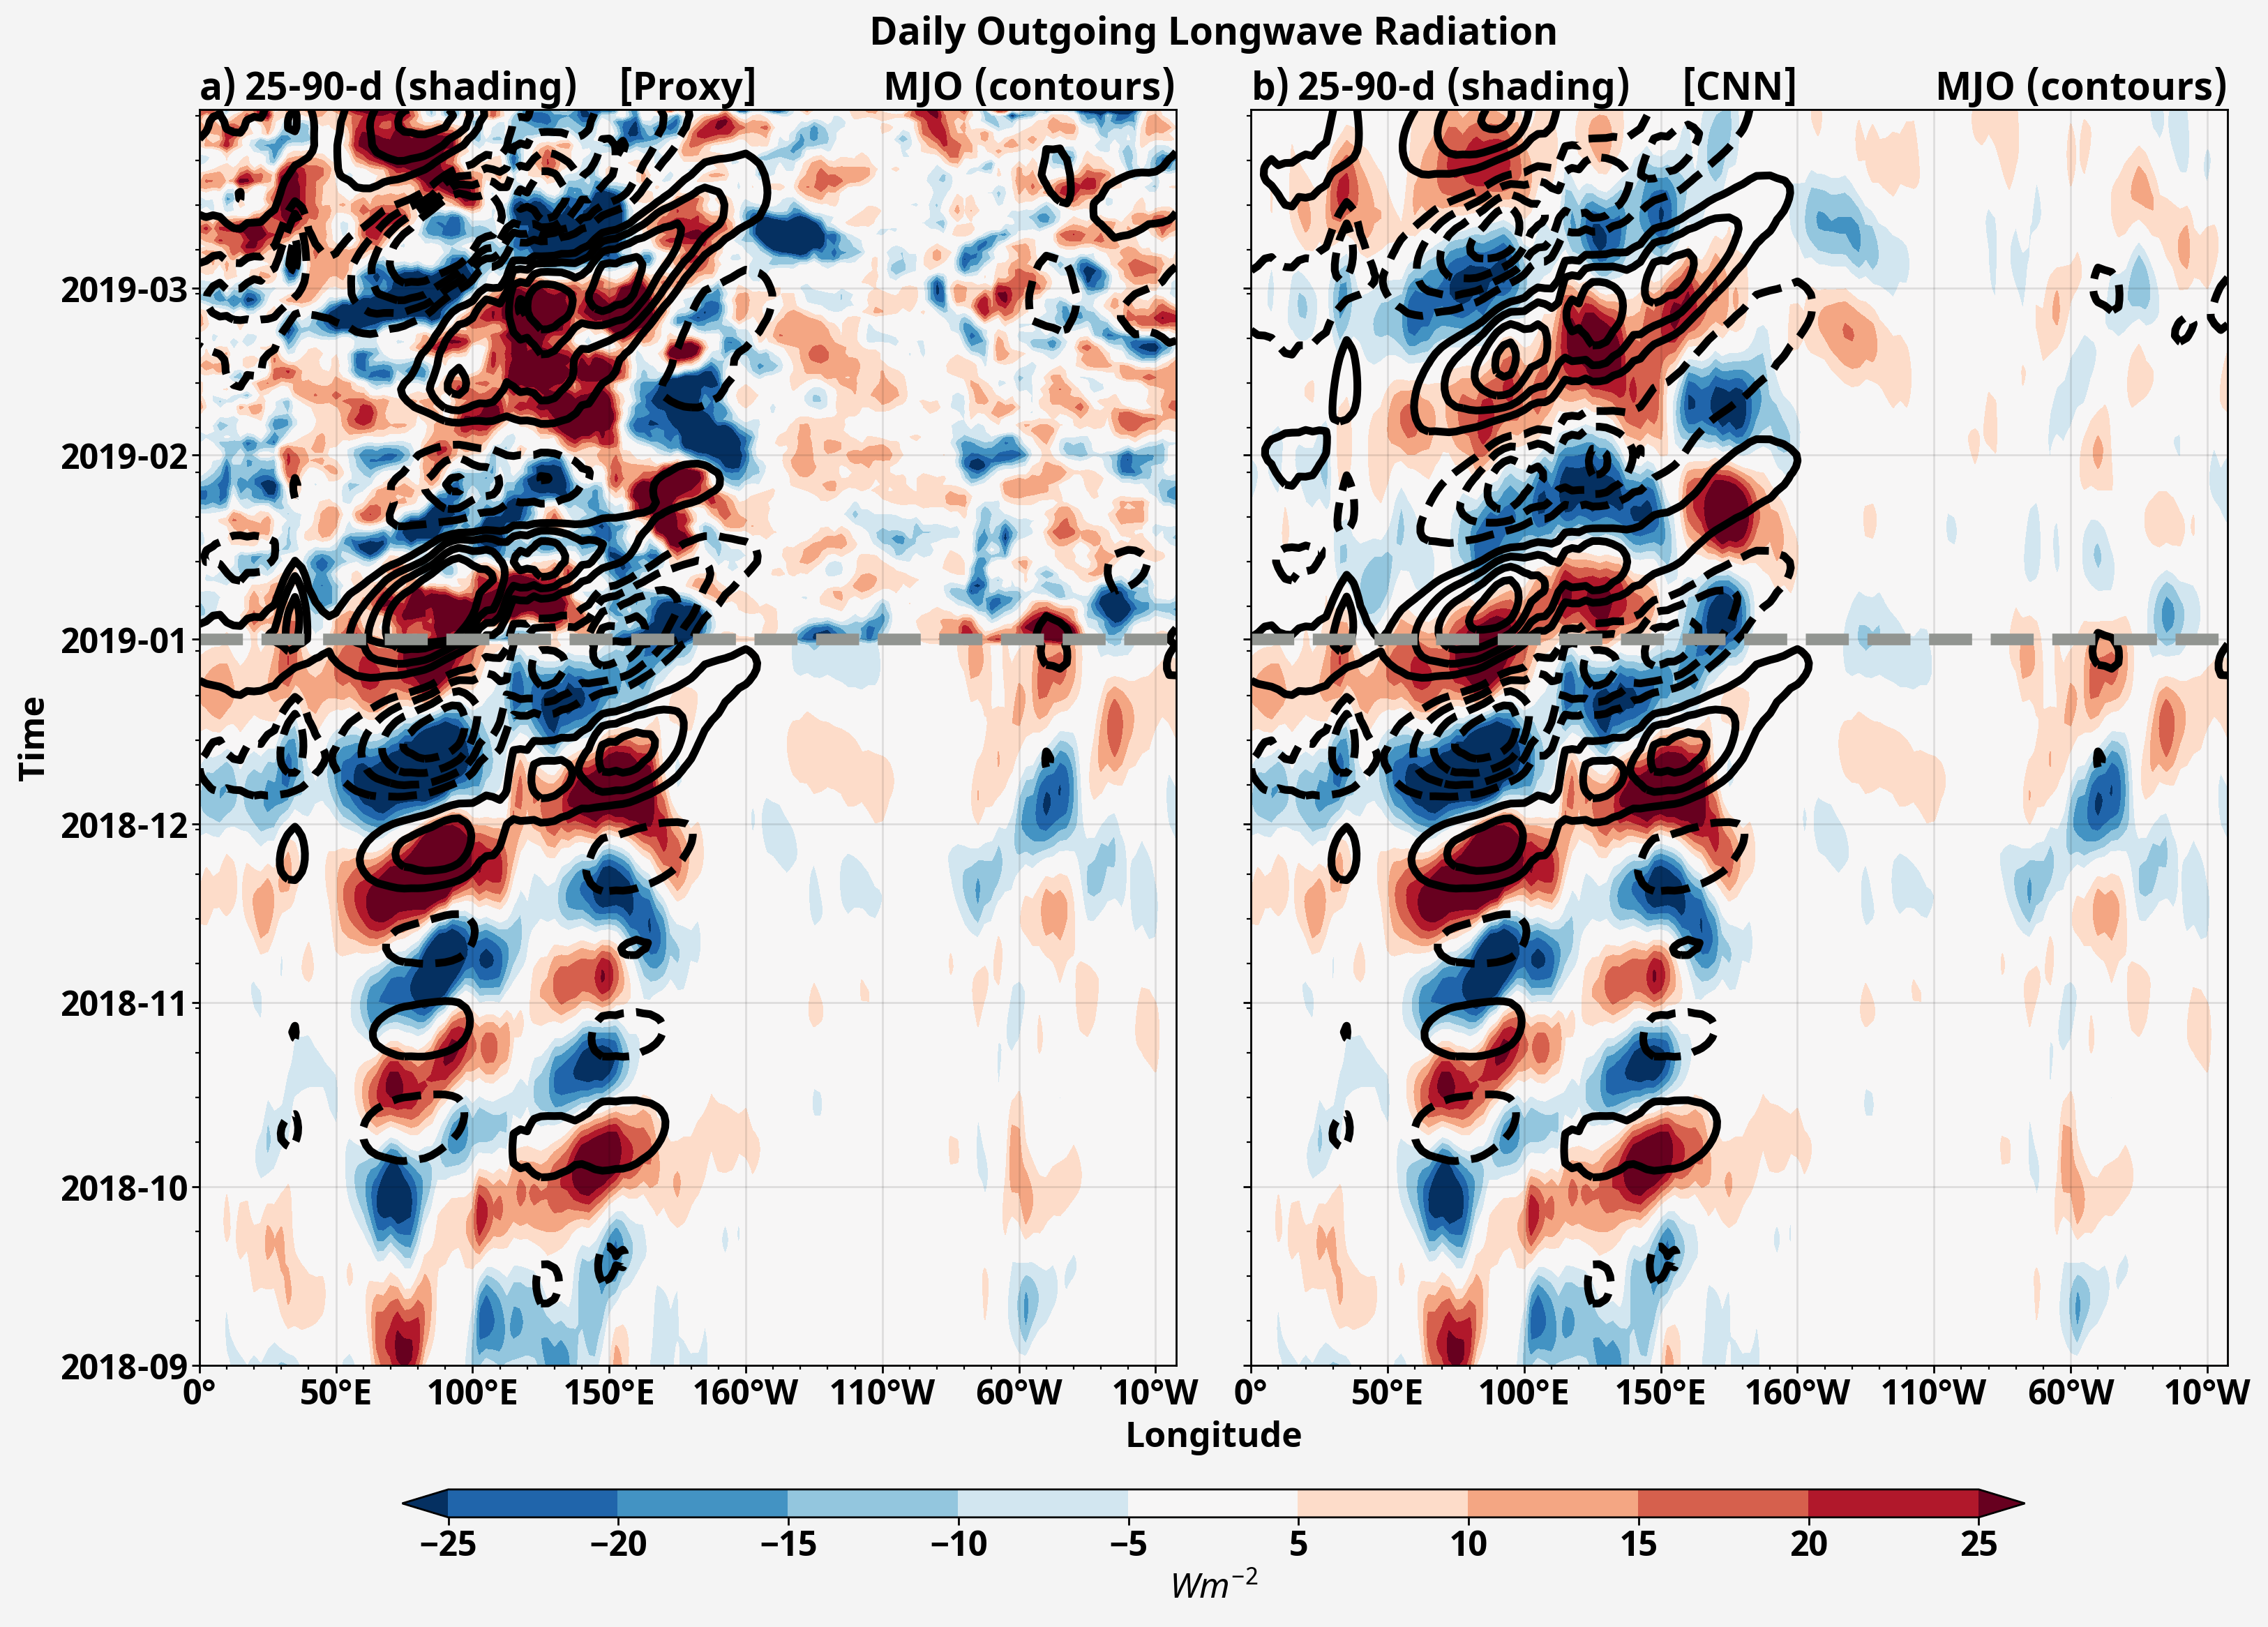

In [12]:
pplt.rc.update({'meta.width':1, 'ticklabelweight':'bold', 'axeslabelweight':'bold','titleweight':'bold','fontname':'Noto Sans','fontsize':18,'titlesize':20})

levels=[-20,-15,-10,-5,5,10,15,20]
levels1 = [-25,-20,-15,-10,-5,5,10,15,20,25]

fig, axs = pplt.subplots(nrows=1,ncols=2,refwidth=7,refheight=9,share=3,span=True)

im1 = axs[0].contourf(olr_comb.sel(lat=slice(-7.5,7.5)).mean('lat'),cmap='RdBu_r',extend='both',levels=levels1,colorbar=False)
axs[0].contour(olr_mjo_comb.sel(lat=slice(-7.5,7.5)).mean('lat'),levels=levels,colors='k',lw=4)
axs[0].axhline(y=datetime(2019,1,1),color='grey',linestyle='--',linewidth=6)
axs[0].format(ltitle=r'25-90-d (shading)',rtitle=r'MJO (contours)',title='[Proxy]')

axs[1].contourf(olrni_cnnlat,cmap='RdBu_r',extend='both',levels=levels1,colorbar=False)
axs[1].contour(olrcnnmjolat,levels=levels,colors='k',lw=4)
axs[1].axhline(y=datetime(2019,1,1),color='grey',linestyle='--',linewidth=6)
axs[1].format(ltitle=r'25-90-d (shading)',rtitle=r'MJO (contours)',title='[CNN]')
axs.format(xlabel='Longitude',ylabel='Time',xformatter='deglon',abc='a)',abcloc='l',suptitle=r'Daily Outgoing Longwave Radiation')
fig.colorbar(im1,location='bottom',shrink= 0.8, width= 0.2,label='$Wm^{-2}$',col=(1,2))

fig.savefig('Fig9.png',dpi=150)

### Figure 10

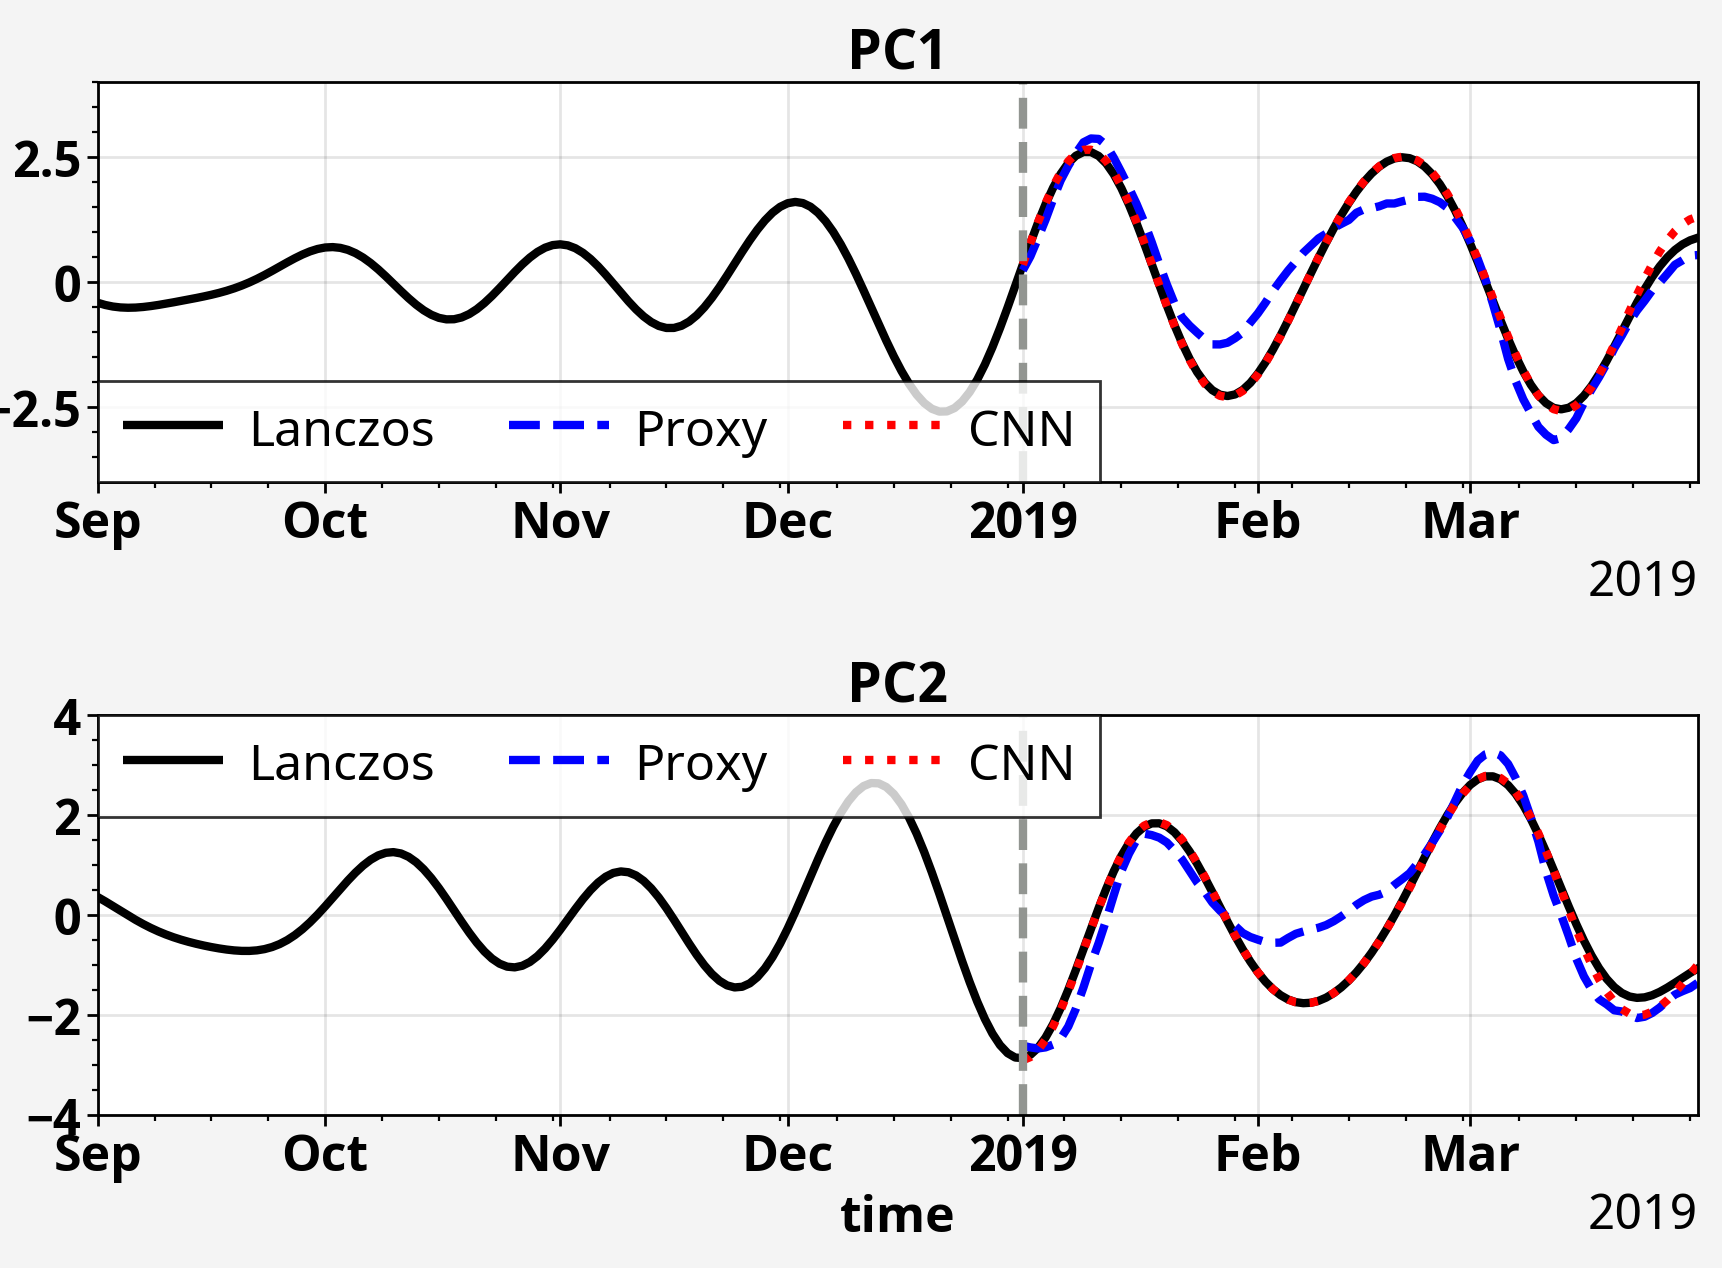

In [13]:
fig, axs = pplt.subplots(nrows=2,ncols=1,refwidth=8,refheight=2,share=1)
axs[0].plot(pca[:,0].sel(time=slice('2018-09-01', '2019-03-31')),color='black',linewidth=3,label='Lanczos')
axs[0].plot(pcb_comb[:,0].sel(time=slice('2019-01-01', '2019-03-31')),color='blue',linestyle='--',linewidth=3,label='Proxy')
axs[0].plot(pcc_comb[:,0].sel(time=slice('2019-01-01', '2019-03-31')),color='red',linestyle=':',linewidth=3,label='CNN')
axs[0].axvline(x=datetime(2019,1,1),color='grey',linestyle='--',linewidth=3)
axs[0].format(title= 'PC1')
axs[0].legend(loc='best')

axs[1].plot(pca[:,1].sel(time=slice('2018-09-01', '2019-03-31')),color='black',linewidth=3,label='Lanczos')
axs[1].plot(pcb_comb[:,1].sel(time=slice('2019-01-01', '2019-03-31')),color='blue',linestyle='--',linewidth=3,label='Proxy')
axs[1].plot(pcc_comb[:,1].sel(time=slice('2019-01-01', '2019-03-31')),color='red',linestyle=':',linewidth=3,label='CNN')
axs[1].axvline(x=datetime(2019,1,1),color='grey',linestyle='--',linewidth=3)
axs[1].format(title= 'PC2')

axs[1].legend(loc='best')
axs.format(xformatter='concise',ylim=(-4,4),xrotation=0)

fig.savefig('pc1pc2.png',dpi=150)

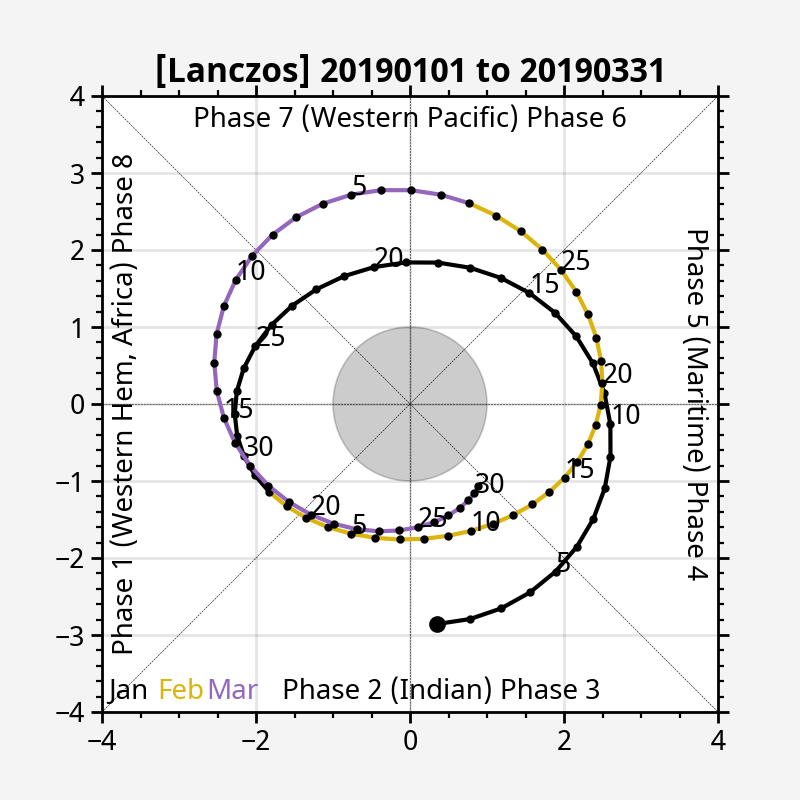

In [14]:
pplt.rc.update({'meta.width':1, 'ticklabelweight':'bold', 'axeslabelweight':'bold','titleweight':'bold','fontname':'Noto Sans','fontsize':10,'titlesize':12})

# set dates to read and plot
datestrt = 20190101
datelast = 20190331

yyyy, mm, dd, hh = pca.time.dt.year, pca.time.dt.month, pca.time.dt.day, pca.time.dt.hour

pc1, pc2 = pca[:,0].values, pca[:,1].values
amp = np.sqrt(pc1**2 + pc2**2)

data = {
    'yyyy': yyyy,
    'mm': mm,
    'dd': dd,
    'hh': hh,
    'pc1': pc1,
    'pc2': pc2,
    'amp': amp
}

# Create a DataFrame using the dictionary
data = pd.DataFrame(data)

DATES = data.yyyy.values*10000 + data.mm.values*100 + data.dd.values
MONTHS = data.mm.values
DAYS = data.dd.values

istrt = np.where(DATES==datestrt)[0][0]
ilast = np.where(DATES==datelast)[0][0]

# subset data to only the dates we want to plot
dates = DATES[istrt:ilast+1]
months = MONTHS[istrt:ilast+1]
days = DAYS[istrt:ilast+1]
PC1 = data.pc1.values[istrt:ilast+1]
PC2 = data.pc2.values[istrt:ilast+1]

indexname = '[Lanczos]'
phase_diagram(indexname,PC1,PC2,dates,months,days,indexname+'_phase','png')

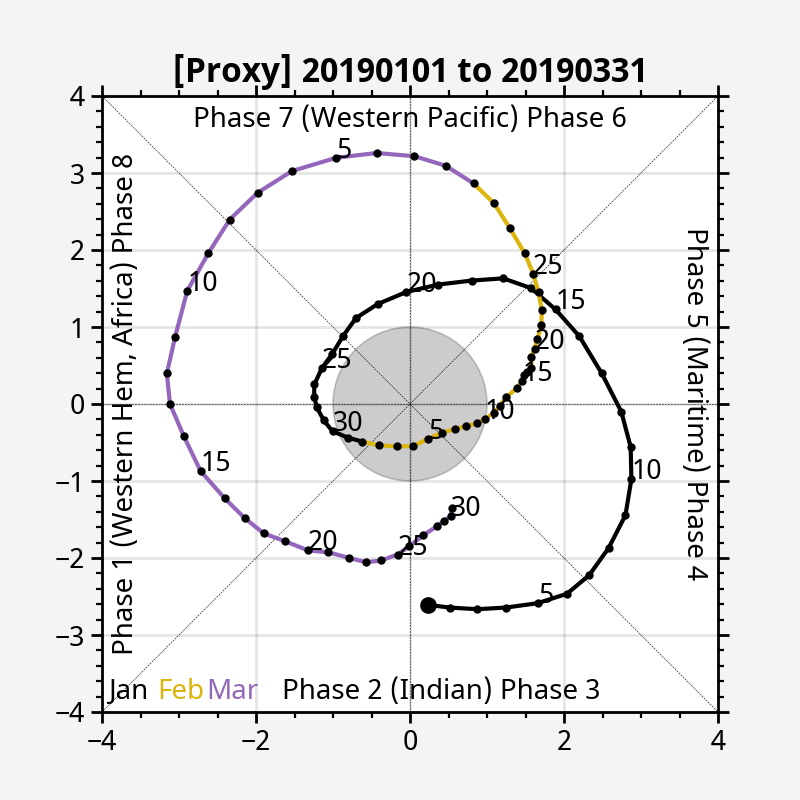

In [15]:
yyyy, mm, dd, hh = pcb_comb.time.dt.year, pcb_comb.time.dt.month, pcb_comb.time.dt.day, pcb_comb.time.dt.hour

pc1, pc2 = pcb_comb[:,0].values, pcb_comb[:,1].values
amp = np.sqrt(pc1**2 + pc2**2)

data = {
    'yyyy': yyyy,
    'mm': mm,
    'dd': dd,
    'hh': hh,
    'pc1': pc1,
    'pc2': pc2,
    'amp': amp
}

# Create a DataFrame using the dictionary
data = pd.DataFrame(data)

DATES = data.yyyy.values*10000 + data.mm.values*100 + data.dd.values
MONTHS = data.mm.values
DAYS = data.dd.values

istrt = np.where(DATES==datestrt)[0][0]
ilast = np.where(DATES==datelast)[0][0]

# subset data to only the dates we want to plot
dates = DATES[istrt:ilast+1]
months = MONTHS[istrt:ilast+1]
days = DAYS[istrt:ilast+1]

PC1 = data.pc1.values[istrt:ilast+1]
PC2 = data.pc2.values[istrt:ilast+1]

indexname = '[Proxy]'
phase_diagram(indexname,PC1,PC2,dates,months,days,indexname+'_phase','png')

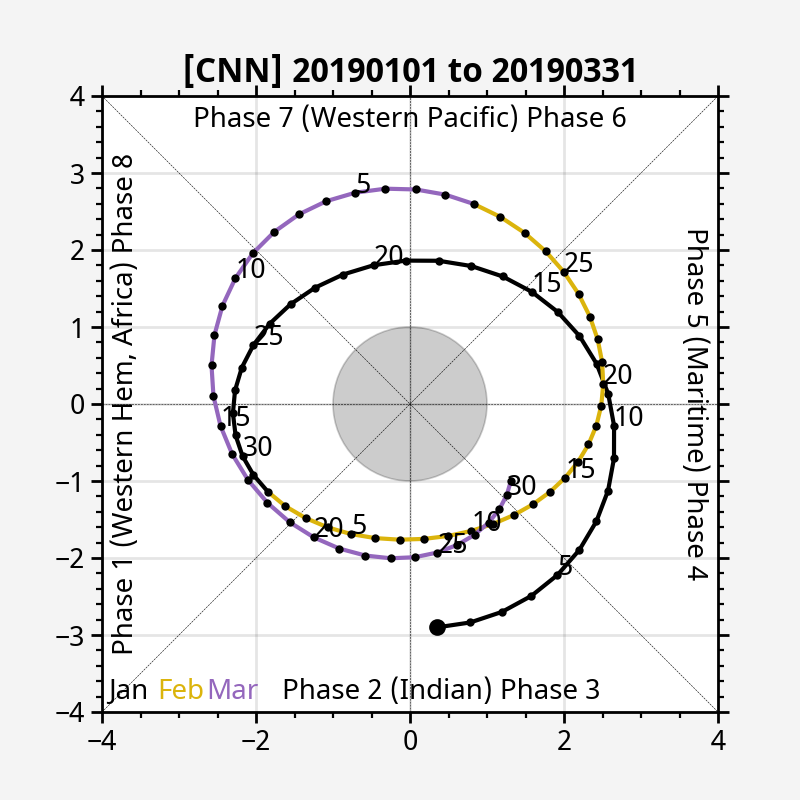

In [16]:
yyyy, mm, dd, hh = pcc_comb.time.dt.year, pcc_comb.time.dt.month, pcc_comb.time.dt.day, pcc_comb.time.dt.hour

pc1, pc2 = pcc_comb[:,0].values, pcc_comb[:,1].values
amp = np.sqrt(pc1**2 + pc2**2)

data = {
    'yyyy': yyyy,
    'mm': mm,
    'dd': dd,
    'hh': hh,
    'pc1': pc1,
    'pc2': pc2,
    'amp': amp
}

# Create a DataFrame using the dictionary
data = pd.DataFrame(data)

DATES = data.yyyy.values*10000 + data.mm.values*100 + data.dd.values
MONTHS = data.mm.values
DAYS = data.dd.values

istrt = np.where(DATES==datestrt)[0][0]
ilast = np.where(DATES==datelast)[0][0]

# subset data to only the dates we want to plot
dates = DATES[istrt:ilast+1]
months = MONTHS[istrt:ilast+1]
days = DAYS[istrt:ilast+1]

PC1 = data.pc1.values[istrt:ilast+1]
PC2 = data.pc2.values[istrt:ilast+1]

indexname = '[CNN]'
phase_diagram(indexname,PC1,PC2,dates,months,days,indexname+'_phase','png')

### Figure 11

In [17]:
f1, psd1 = signal.periodogram(olri_lcz.sel(time=slice('2018','2019'),lat=slice(-7.5,7.5),lon=slice(160,190)).mean({'lat','lon'},skipna=True))
f2, psd2 = signal.periodogram(exb.sel(time=slice('2018','2019'),lat=slice(-7.5,7.5),lon=slice(160,190)).mean({'lat','lon'},skipna=True))
f3, psd3 = signal.periodogram(olrnicnn.sel(time=slice('2018','2019'),lat=slice(-7.5,7.5),lon=slice(160,190)).mean({'lat','lon'},skipna=True))

f1b, psd1b = signal.periodogram(olrlcz_mjo.sel(time=slice('2018','2019'),lat=slice(-7.5,7.5),lon=slice(160,190)).mean({'lat','lon'},skipna=True))
f2b, psd2b = signal.periodogram(olranom_mjo.sel(time=slice('2018','2019'),lat=slice(-7.5,7.5),lon=slice(160,190)).mean({'lat','lon'},skipna=True))
f3b, psd3b = signal.periodogram(olrcnn_mjo.sel(time=slice('2018','2019'),lat=slice(-7.5,7.5),lon=slice(160,190)).mean({'lat','lon'},skipna=True))

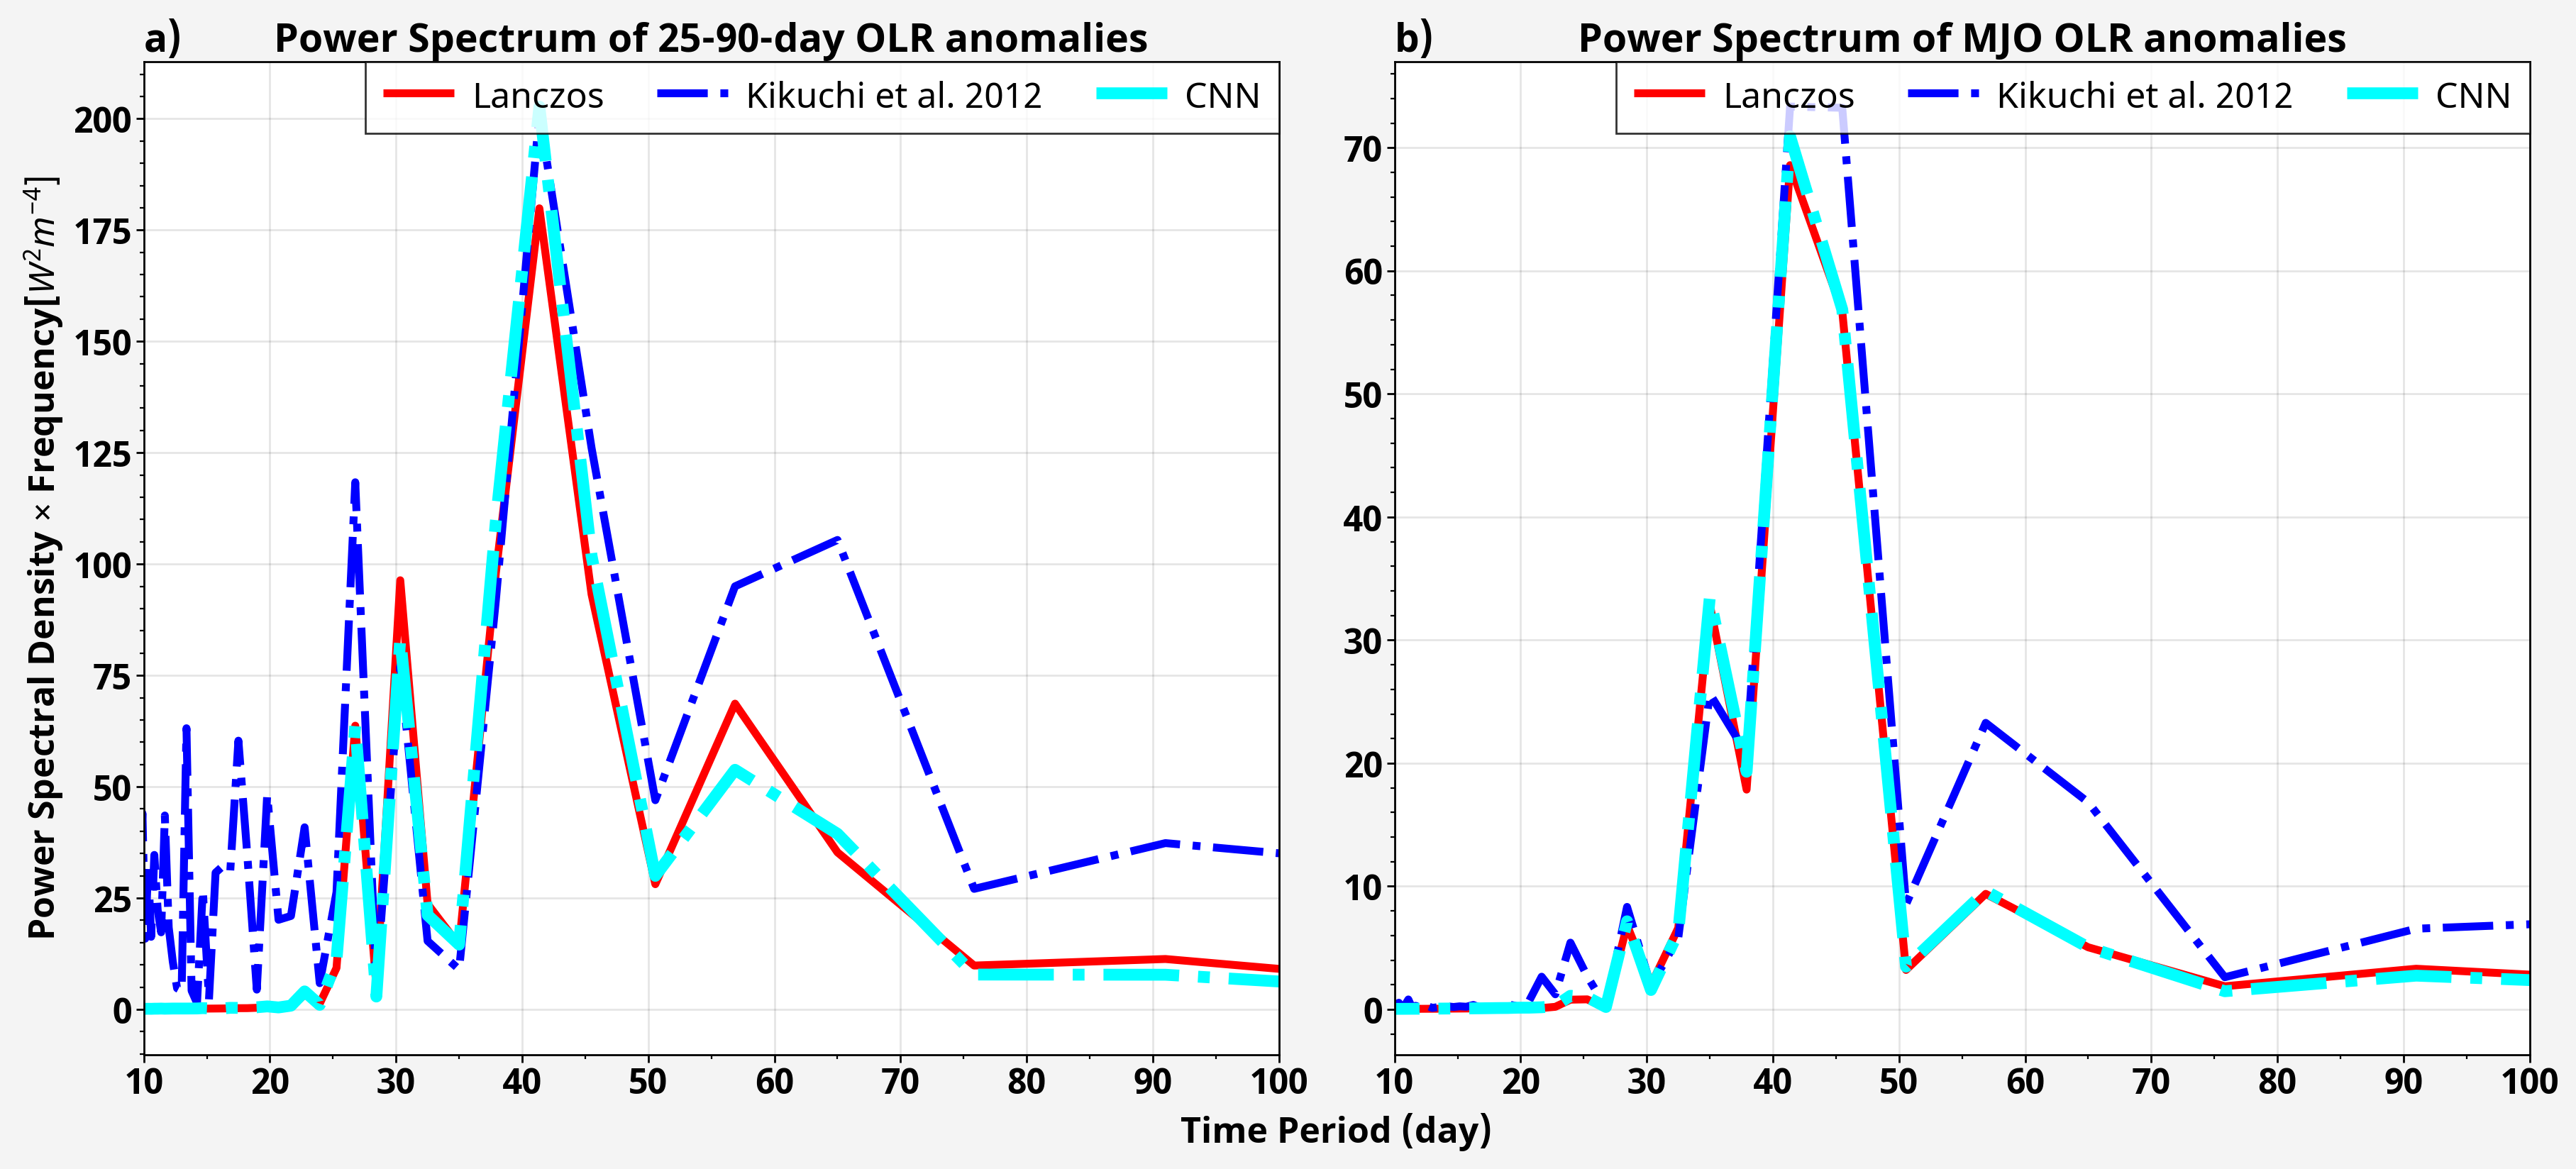

In [18]:
pplt.rc.update({'meta.width':1, 'ticklabelweight':'bold', 'axeslabelweight':'bold','titleweight':'bold','fontname':'Noto Sans','fontsize':18,'titlesize':20})

fig, axs = pplt.subplots(nrows=1,ncols=2,refwidth=8,refheight=7,share=1)

axs[0].plot(1/f1[3:],f1[3:]*psd1[3:],color='r',lw=4,label='Lanczos')
axs[0].plot(1/f2[3:],f2[3:]*psd2[3:],color='b',lw=4,ls='-.',label='Kikuchi et al. 2012')

axs[0].plot(1/f3[3:],f3[3:]*psd3[3:],color='cyan',lw=6,ls='-.',label='CNN')
axs[0].legend(loc='ur')
#axs.ticklabel_format(axis='y', style='sci', scilimits=(-3,-3))
#axs[0].format(xlim=(10,100),xlocator=10,xminorlocator=5,title=r'Power Spectral Density $\times$ Frequency',ylabel=r'$W^2m^{-4}$',xlabel='Time Period (day)')


axs[1].plot(1/f1b[3:],f1b[3:]*psd1b[3:],color='r',lw=4,label='Lanczos')
axs[1].plot(1/f2b[3:],f2b[3:]*psd2b[3:],color='b',lw=4,ls='-.',label='Kikuchi et al. 2012')

axs[1].plot(1/f3b[3:],f3b[3:]*psd3b[3:],color='cyan',lw=6,ls='-.',label='CNN')
axs[1].legend(loc='ur')

axs[0].format(title=r'Power Spectrum of 25-90-day OLR anomalies')
axs[1].format(title=r'Power Spectrum of MJO OLR anomalies')
axs.format(xlim=(10,100),xlocator=10,xminorlocator=5,suptitle=r'',ylabel=r'Power Spectral Density $\times$ Frequency[$W^2m^{-4}]$',xlabel='Time Period (day)',abc='a)',abcloc='l')

fig.savefig('Fig11.png',dpi=150)